# Monte Carlo resource assessments in Python

We explore in this article how to easily generate your own Monte Carlo simulations in Python using a resource assessment as an example. The methodologies detailed here can however be adapted to any problem where a Monte Carlo simulation is desired.<!--more-->
There are many advantages to using Python for this: 
- It's totally free &mdash; no need for any extensions to Excel (or for Excel for that matter...);
- It's not a black box &mdash; you know what is happening under the hood;
- It's fully customizable &mdash; you can finally tailor the solution to your problem, including the outputs;
- It is easy to export your results to a wide variety of destinations, including raster and vector images, Excel spreadsheets, or even \\(\LaTeX\\) documents.

Though some familiarity with Python is desirable, advanced knowledge of the language isn't needed and the code provided below should be relatively easy to adapt to your own needs. We will mostly be using [SciPy's](https://www.scipy.org) [*statistical submodule*](https://docs.scipy.org/doc/scipy/reference/stats.html) for calculations, [Pandas](https://pandas.pydata.org) for generating and summarizing results, and a combination of [Matplotlib](https://matplotlib.org)/[seaborn](https://seaborn.pydata.org) for plotting. Using seaborn for plotting automatically handles a lot of the plot formatting.

First, we will see how we can generate random variates from a known distribution. We will then apply this knowledge and generate random variates for all the input parameters for a resource calculation, before calculating the corresponding resource distribution and creating some reporting elements. Finally, we will discuss potential next steps to take things a little further.


## Generating random variates from a distribution with SciPy

Let's generate 10,000 random variates from a normal distribution with a mean of 3 and a standard deviation of 2. For this, we can use SciPy's [*norm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) continuous distribution class to instantiate a normal distribution object with the desired parameters<!--: `distribution = norm(loc=3, scale=2)`-->. We can then use its [*rvs( )*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.rvs.html) method to generate \\(n\\) random variates.

### Import necessary libraries

In [31]:
from math import log, exp

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import (norm, lognorm, 
                         gamma, percentileofscore)

import seaborn as sns

### Generate random variates and ideal distribution

In [32]:
# instantiate normal distribution object with mean=3, std=2
distribution = norm(loc=3, scale=2)

# generate n random variates using 'rvs' method
n = 10_000
rv = distribution.rvs(int(n))

# generate (x, y) data for the ideal distribution
x = np.linspace(-6.5, 8.5)
probability = distribution.pdf(x)

### Plot histogram of results

Seaborn has a very handy function [*histplot*](https://seaborn.pydata.org/generated/seaborn.histplot.html) for plotting histograms we can use:

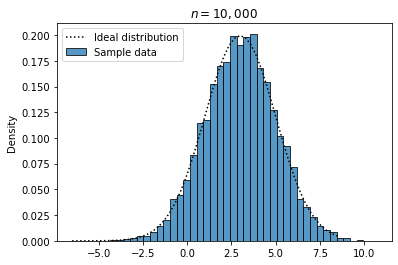

In [33]:
# create Pyplot axes for plotting results
fig, ax = plt.subplots()

# plot a histogram of the random variates with seaborn
sns.histplot(
    rv,                    # unbinned data to plot
    bins=40,               # number of bins/bars
    stat='density',        # method for normalising bar height
    ax=ax,                 # axes on which to plot the histogram
    label='Sample data'    
)
    
# plot the ideal distribution
ax.plot(x, probability, c='k', ls=':', 
        label='Ideal distribution')
    
# format title and add legend to plot
ax.set_title("$n={:,.0f}$".format(n))
ax.legend(loc='upper left')

plt.show()

> We set the `stat` argument to `density` for the histogram to normalize its total area to 1 so it can be compared to our ideal distribution.

### A note on distributions and their parameters in SciPy

In addition to the normal distribution used above, there are many others available in SciPy, all featuring similar functionalities. The average geoscientist should easily find what they need:

- Log-normal ([*lognorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html)) 
- Beta ([*beta*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html))
- Triangular ([*triang*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.triang.html))
- Truncated normal ([*truncnorm*](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.truncnorm.html))
- And many more (full list [here](https://docs.scipy.org/doc/scipy/reference/stats.html#continuous-distributions))

The parameters used to define these distributions are not always as user friendly as one might hope, and depending on the distribution some calculations may be needed to get to them. To make things a little simpler going forward, we will therefore create some functions to instantiate SciPy distribution objects using more user friendly parameters, especially for the log-normal distribution which we will also be using. The two functions below do this taking the \\(P_{90}\\) and \\(P_{10}\\) as input parameters; similar functions could be written for other distributions if needed.

In [34]:
# define easy to call normal distribution
def norm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    mean = (p90 + p10) / 2 
    std = (p10 - p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    return norm(loc=mean, scale=std)
    
# define easy to call log-normal distribution
def lognorm_dist(p90, p10):
    if p90 > p10:
        p90, p10 = p10, p90
    std = log(p10 / p90) / (norm.ppf(0.9) - norm.ppf(0.1))
    mean = (log(p10) - 2**0.5 * std 
            * (gamma.ppf(0.8, a=0.5, scale=1))**0.5)
    return lognorm(s=std, scale=exp(mean))

## Generating random variates for volumetric parameters

We can now define distributions for the input parameters of our resource assessment and generate random variates for each parameter. We will store these in a Python `dict` so we can use this dictionary's keys to create corresponding columns in a Pandas DataFrame, and then loop through these keys to populate each column with appropriate random variates.

In [35]:
# define dictionary of volumetric parameters
params = {
    'GRV': lognorm_dist(p90=100e6, p10=250e6),
    'NTG': norm_dist(p90=0.6, p10=0.8),
    'Porosity': norm_dist(p90=0.125, p10=0.225),
    'Sw': norm_dist(p90=0.15, p10=0.45),
    'FVF': norm_dist(p90=1.1, p10=1.3),
    'RF': norm_dist(p90=0.15, p10=0.25),
}

# number of samples in our simulation
num_samples = 100_000

# create an empty DataFrame with a column for each input parameter
realisations = pd.DataFrame([], columns=params)


# loop through key, value pairs from the parameters
# dictionary generating their random variates
# and storing the result in the correct column of
# the DataFrame
seed = 2
for param, dist in params.items():
    realisations[param] = dist.rvs(
        num_samples,
        random_state=seed
    )
    seed = seed*2

> Note: defining the `random_state` argument in `rvs` is not a requirement. I have opted to do this here so the outputs are always the same (still 'random', just the same 'random' every time). I have been cautious to change the random state for each parameter to avoid unwanted correlation between parameters.


### Random variates summary

Using Pandas' [*describe( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html?highlight=describe) method and specifying a list of `percentiles`, we can easily generate a table of summary statistics for the input parameters. Along with our chosen percentiles, this will also provide mean, standard deviation, and min & max for each parameter. This is useful to check we have experimental distributions that match our desired ones.

In [36]:
realisations.describe(percentiles=[0.1, 0.5, 0.9])

,GRV,NTG,Porosity,Sw,FVF,RF
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684093e+08,0.699864,0.174904,0.299951,1.200344,0.199975
std,6.246200e+07,0.077804,0.039007,0.117216,0.078205,0.039172
min,3.837896e+07,0.339578,-0.001573,-0.189080,0.853751,0.036569
10%,9.992398e+07,0.600324,0.124994,0.149439,1.100215,0.149634
50%,1.578452e+08,0.699836,0.174726,0.299628,1.200399,0.200028
90%,2.500421e+08,0.799543,0.225139,0.449945,1.300464,0.250159
max,7.547270e+08,1.029001,0.331260,0.781936,1.528683,0.363993


Close inspection reveals values for net-to-gross, porosity and \\(S_w\\) that fall outside of desired bounds. We can address this with Pandas' [*clip( )*](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.clip.html) method and clip these outlier values to more reasonable ones.

In [37]:
realisations['Porosity'] = realisations['Porosity'].clip(lower=0.1)
realisations['Sw'] = realisations['Sw'].clip(lower=0.15, upper=0.70)
realisations['NTG'] = realisations['NTG'].clip(upper=1)

realisations.describe(percentiles=[0.1, 0.5, 0.9])

,GRV,NTG,Porosity,Sw,FVF,RF
count,1.000000e+05,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.684093e+08,0.699863,0.175310,0.305519,1.200344,0.199975
std,6.246200e+07,0.077800,0.038069,0.107172,0.078205,0.039172
min,3.837896e+07,0.339578,0.100000,0.150000,0.853751,0.036569
10%,9.992398e+07,0.600324,0.124994,0.150000,1.100215,0.149634
50%,1.578452e+08,0.699836,0.174726,0.299628,1.200399,0.200028
90%,2.500421e+08,0.799543,0.225139,0.449945,1.300464,0.250159
max,7.547270e+08,1.000000,0.331260,0.700000,1.528683,0.363993


## Volumetric calculations and reporting


### Calculating resource distribution

The calculation below assumes that the gross rock volume is in \\(m^3\\) and returns a result in \\(mmbbl\\).

In [38]:
realisations['STOOIP'] = (realisations['GRV']
                     * realisations['NTG']
                     * realisations['Porosity']
                     * (1 - realisations['Sw'])
                     / realisations['FVF']
                     / 1_000 / 159)
realisations['Resource'] = realisations['STOOIP'] * realisations['RF']

### Plotting the results

Let's use seaborn again to plot a summary histogram and an empirical cumulative distribution function of the STOOIP distribution:

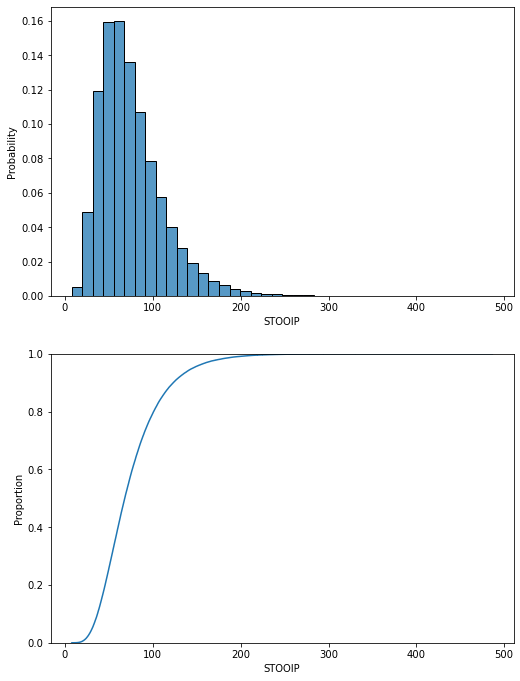

In [39]:
fig, ax = plt.subplots(nrows=2, figsize=(8.3, 11.7))

# display histogram of distribution in first subplot
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)

# display empirical cumulative distribution function in second subplot
sns.ecdfplot(realisations.STOOIP, ax=ax[1])

plt.show()

With a little bit of extra code, we can add some useful information to our plots like the \\(P_{90}\\), \\(P_{50}\\), \\(P_{10}\\) and mean values:

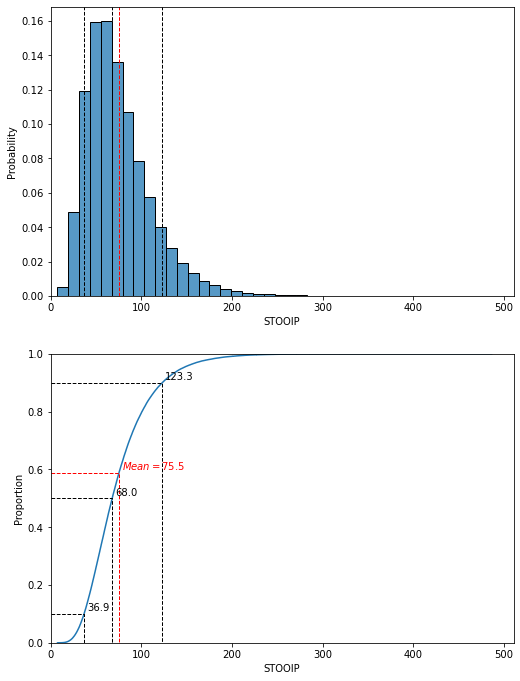

In [40]:
# first 3 lines are copied from above
fig, ax = plt.subplots(nrows=2, figsize=(8.3, 11.7))
sns.histplot(realisations.STOOIP, ax=ax[0], stat='probability', bins=40)
sns.ecdfplot(realisations.STOOIP, ax=ax[1])

# display key percentiles and mean on plots
ax[0].set_xlim(left=0)
ax[0].set_ylim(ax[0].get_ylim()) # freeze ylim
ax[1].set_xlim(ax[0].get_xlim())
y_max = ax[0].get_ylim()[1]
ls = {'c':'k', 'ls': '--', 'lw': '1'}
for p in [0.1, 0.5, 0.9]:
    q = realisations.STOOIP.quantile(p)
    ax[0].plot([q]*2, [0, y_max], **ls)
    ax[1].plot([0] + [q]*2,
               [p]*2 + [0],
               **ls)
    ax[1].annotate('{:.1f}'.format(q), 
                   (q, p),
                   xytext=(3, 3),
                   textcoords='offset pixels',
                   c='k')
    
ls_mean = {'c':'r', 'ls': '--', 'lw': '1'}
mean = realisations.STOOIP.mean()
Pmean = percentileofscore(realisations.STOOIP,
                          mean, kind='weak') / 100
ax[0].plot([mean]*2, [0, y_max],
           **ls_mean)
ax[1].plot([0] + [mean]*2, [Pmean]*2 + [0],
           **ls_mean)
ax[1].annotate('$Mean={:.1f}$'.format(mean), 
               (mean, Pmean),
               xytext=(3, 3),
               textcoords='offset pixels',
               c='r')

plt.show()

### Summary statistics

And we can reuse the `describe()` method to create a new DataFrame with summary statistics for both our input parameters and STOOIP/resource distributions. We take it one step further this time by transposing the DataFrame so the parameters/results are now rows, and only retaining some of the statistics that we reorder. We can also update the column names to something more useful.

In [41]:
summary = realisations.describe(percentiles=[0.1, 0.5, 0.9])

# transpose summary
summary = summary.T

# select columns in desired order
summary = summary[['min', '10%', '50%', '90%', 'max', 'mean']]

# update column names
summary.columns = ['Min', 'P90', 'P50', 'P10', 'Max', 'Mean']

summary

,Min,P90,P50,P10,Max,Mean
GRV,3.837896e+07,9.992398e+07,1.578452e+08,2.500421e+08,7.547270e+08,1.684093e+08
NTG,3.395776e-01,6.003238e-01,6.998363e-01,7.995425e-01,1.000000e+00,6.998628e-01
Porosity,1.000000e-01,1.249936e-01,1.747259e-01,2.251387e-01,3.312596e-01,1.753103e-01
Sw,1.500000e-01,1.500000e-01,2.996280e-01,4.499451e-01,7.000000e-01,3.055189e-01
FVF,8.537509e-01,1.100215e+00,1.200399e+00,1.300464e+00,1.528683e+00,1.200344e+00
RF,3.656859e-02,1.496338e-01,2.000276e-01,2.501588e-01,3.639929e-01,1.999747e-01
STOOIP,7.488700e+00,3.692494e+01,6.797166e+01,1.232692e+02,4.868506e+02,7.546385e+01
Resource,1.107679e+00,6.826468e+00,1.334368e+01,2.550345e+01,1.008095e+02,1.509398e+01


### Export results

Matplotlib provides the option to save a figure as a file, with multiple file formats available, including PDF, SVG, PNG and JPEG. Likewise, Pandas allows direct exports to a number of formats, including CSV and Excel *.xlsx* spreadsheets.

In [42]:
# export STOOIP historgram to a PDF file
fig.savefig('./STOOIP.pdf')

# export summary statistcs to an Excel spreadsheet
summary.to_excel('./summary.xlsx')

## Summary

We have seen in this article how to generate random variates from a known distribution and applied this to generate random variates for the input parameters of our resource calculation.
using Pandas for STOOIP/resource calculations and exporting tables to Excel
using Matplotlib/seaborn to plot results and export.



## Where next?

- [ ] correlated variables
- [ ] area depth from grid
- [ ] GRV from 2 grids
- [ ] risked distributions
- [ ] multiple prospects / consolidation

### Different workflows

- area-depth
- 1/2 grids

### More advanced sampling

The `rvs` method is already adding a layer of abstraction in that it is handling all the sampling effort. Under the hood, it is generating \\(n\\) pseudo-random numbers from a uniform distribution over \\( \left[0,1\right]\\) and using the inverse of an appropriate cumulative distribution function to convert these to random variates of the desired distribution. With increasing numbers of parameters, this could lead to undersampling of parts of the sample space. One solution to address this is by using brute force and increasing the number of samples.

(sensitivity figure/discussion here - 100,000 samples/200 realisations).


<figure>
    <p>
        <a href="./assets/1-sensitivity.png">
        <img src="./assets/1-sensitivity.png" alt="png" width="60%" />
        </a>
        <figcaption><center><i><b>Figure 1:</b> Figure title.</i></center></figcaption>
    </p>
</figure>

    
Another solution is to ditch `rvs` and take control of sampling. In this case we need to generate our own samples over \\( \left[0,1\right]\\) and transform them to random variates with the `ppf` method which provides an inverse cumulative probability function for a distribution. There are two main advantages to doing this:

1. You can opt for more advanced sampling techniques like Latin hypercubes, orthogonal sampling, or low-discrepancy sequences; this is no longer pseudo-random though and enters the realm of Quasi Monte Carlo simulation. Given the low number of dimensions typical of resource calculations it is likely to offer only limited advantages. If you are using Scipy version 1.7 or later, it features a [*Quasi Monte Carlo*](https://docs.scipy.org/doc/scipy/reference/stats.qmc.html) module that provides algorithms for Latin hypercubes and low-discrepancy sequences as well as some functionalities handling covariances between dimensions.

2. 


### Portfolio consolidations

pseudo-randomness, sampling, LHC etc. SciPY QMC...
